<a href="https://colab.research.google.com/github/AdamPeetz/PlaneGAN/blob/main/DCGAN_V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative adversarial networks: Deep convolutional architecture 

 
 

Deep Convolutional Generative Adversarial Networks (DCGANs) are a GAN architecture that generate images by upscaling noise through a series of convolutional layers. 

In [ ]:
# import libraries
from numpy import zeros
from numpy import ones
from numpy.random import randn, random
from numpy.random import randint
from numpy import vstack
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose, Conv3DTranspose
from keras.layers import LeakyReLU, ReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot
import tensorflow as tf
import numpy as np
import pathlib

import os, shutil 
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Model architecture: Defining a discriminator 

 
 

A discriminator network is used to predict whether an image is real or fake. Loss from the discriminator is used to train the generator to produce more convincing fake images over time. 

 
 

The discriminator takes an input that is the same size as the generator's output. The input tensor is down sampled through convolutional layers and flattened to make a prediction about whether that tensor is fake or real.  

 
 

Dropout is included in each layer to stabilize GAN training. A stride of 2 is used instead of pooling layers to reduce the size of the tensor in each layer. A kernel initializer is added to start the network weights with a normal distribution centered around 0. LeakyReLU is used as an activation function to prevent a vanishing gradient in the model.  

 
 

The discriminator architecture of a DCGAN can be simple as it only must predict whether an image is real or fake which is an easy task for the model. 

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(128,128,3)):
	init = RandomNormal(mean=0.0, stddev=0.02)
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 64x64
	model.add(Conv2D(98, (3,3), strides=(2,2), kernel_initializer=init, padding='same'))
	model.add(Dropout(0.4))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 32x32
	model.add(Conv2D(128, (3,3), strides=(2,2), kernel_initializer=init, padding='same'))
	model.add(Dropout(0.4))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 16x16
	model.add(Conv2D(192, (3,3), strides=(2,2), kernel_initializer=init, padding='same'))
	model.add(Dropout(0.4))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 8x8
	model.add(Conv2D(256, (3,3), strides=(2,2), kernel_initializer=init, padding='same'))
	model.add(Dropout(0.4))
	model.add(LeakyReLU(alpha=0.2))
 	# downsample to 4x4
	model.add(Conv2D(256, (3,3), strides=(2,2), kernel_initializer=init, padding='same'))
	model.add(Dropout(0.4))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


# Model architecture: Defining a generator 

 
 

A generator network is used to upscale noise into an image tensor. It takes a n-dimensional hypersphere as input and transposes that noise into a manifold of nodes that are reshaped into a cluster of small tensors. These tensors are upscaled in successive layers to create larger tensors which are mapped into a 3-layer image tensor of the desired size. 

 
 

The generator uses Conv2DTranspose layers with a stride size of 2 to double the size of the tensor in each layer. Several best practices are employed to stabilize the generator during training. A filter size that is a factor of the stride size is used. A kernel initializer is employed to start the model with weights from a normal distribution centered around 0. LeakyReLU is used as an activation function to prevent vanishing gradients in the model except in the last layer which uses a tanh activation function. 

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	init = RandomNormal(mean=0.0, stddev=0.02)
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 1024 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 1024)))
	# upsample to 8x8
	model.add(Conv2DTranspose(2048, (4,4), strides=(2,2), kernel_initializer=init, padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(1024, (4,4), strides=(2,2), kernel_initializer=init, padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(512, (4,4), strides=(2,2), kernel_initializer=init, padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 	# upsample to 64x64
	model.add(Conv2DTranspose(256, (4,4), strides=(2,2), kernel_initializer=init, padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), kernel_initializer=init, padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# Support equations: Defining the gan, loading images, generating samples 

 
 

## define_gan 

 
 

Combines the generator and discriminator into a single model. The weights on the discriminator are frozen in the combined model. This allows the loss during training to be back propagated through the generator only, improving its image generation over time. 

 
 

## load_custom_image_set 

 
 

Allows a custom dataset to be loaded for model training from a file directory location.  

 
 

## smooth_positive_labels 

 
 

Takes the positive hard label values of 1 and smooths them to a value between 0.7 and 1.2. This practice is recommended to stabilize GAN training. 

 
 

## generate_real_samples 

 
 

Creates a 4-dimensional tensor of real images from the dataset.  

 
 

## generate_latent_points 

 
 

Creates an array of points to use as input for the generator model. This array is drawn from a n-dimensional hypersphere. 

 
 

## generate_fake_samples 

 
 

Creates a 4-dimensional tensor of fake images from predictions made by the generator model.  

 
 

 



In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

#load a custom image dataset 
def load_custom_image_set(dataroot,resizedim,directorylevels):
    #image parse function
    def parse_image(filename):
        parts = tf.strings.split(filename, os.sep)
        label = parts[-2]
        image = tf.io.read_file(filename)
        image = tf.io.decode_jpeg(image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [resizedim,resizedim])
        image = (image * 2) -1
        return image, label
    
    data_root = pathlib.Path(dataroot)
    if directorylevels == 1:
      list_ds = tf.data.Dataset.list_files(str(data_root/'*/*'))
    if directorylevels == 2:
      list_ds = tf.data.Dataset.list_files(str(data_root/'*/*/*'))
    images_ds = list_ds.map(parse_image)
    #https://stackoverflow.com/questions/70535683/extract-data-from-tensorflow-dataset-e-g-to-numpy
    images = np.asarray(list(images_ds.map(lambda x, y: x)))
    return images

# label smoothing function
def smooth_positive_labels(y):
	return y - 0.3 + (random(y.shape) * 0.5)
                  
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	# apply label smoothing
	y = smooth_positive_labels(y)
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	input_tensor = tf.convert_to_tensor(x_input)
	X = g_model(input_tensor)
	X = X.numpy()
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# Support equations: Training metrics and output 

 
 

Model metrics are used to understand the performance of a GAN over time. A GAN will never converge on a solution and must be evaluated in other ways such as reviewing samples of images produced by the generator or monitoring the interaction of loss curves from the generator and discriminator. 

 
 

## save_plot 

 
 

Saves a sample of images from the GAN. 

 
 

## plot_history 

 
 

Creates a line plot of loss from the generator and discriminator. 

 
 

## summarize_performance 

 
 

Evaluates the model's ability to distinguish between fake and real images. Then saves a copy of the model and a sample of the images produced at that step in a file directory. 

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
#	example = (examples + 1) * 255
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = '/content/gdrive/My Drive/planegan/sample_output/generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d1_hist, label='d-real')
	pyplot.plot(d2_hist, label='d-fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	# plot discriminator accuracy
	pyplot.subplot(2, 1, 2)
	pyplot.plot(a1_hist, label='acc-real')
	pyplot.plot(a2_hist, label='acc-fake')
	pyplot.legend()
	# save plot to file
	pyplot.savefig('/content/gdrive/My Drive/planegan/saved_models/plot_line_plot_loss.png')
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = '/content/gdrive/My Drive/planegan/saved_models/generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# Training a GAN: Custom training loop 

 
 

GAN training requires a custom training loop.  

 
 

First the training loop uses a half batch of real or fake images to independently train the discriminator to predict if an image is real or fake. It then trains the combined GAN on a batch of fake images and uses the loss to train the weights in the generator only. This process trains the generator to produce more realistic images over time. 

 
 

Several functions are added to the end of the training loop to record metrics at certain points during the training run. 

In [ ]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=300, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# define half batches for training
	half_batch = int(n_batch / 2)
  # prepare lists for storing stats each iteration
	d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss
			if (j+1) % 5 == 0:
				print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
	 		# save plot to directory
			plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
		# record training metrics
		if (i+1) % 2 == 0:
			d1_hist.append(d_loss1)
			d2_hist.append(d_loss2)
			g_hist.append(g_loss)
			a1_hist.append(d_acc1)
			a2_hist.append(d_acc2)

# Loading Training Data 

 
 

Load training data from a file directory with multiple levels. This supports file directories where images have been divided based on classes (directorylevels=1) or further segmented into training and test sets inside those class folders (directorylevels=2). It also allows input images to be resized to the required dimensions for the GAN. 

 

In [ ]:
# load image data
image_path = "/content/gdrive/My Drive/planegan/airplanes_resized/"
resizedim = 128
directorylevels = 1
dataset = load_custom_image_set(image_path,resizedim,directorylevels)

# EDA: Displaying image samples 

 
 

GANs should be evaluated based on their ability to produce images that are like the training dataset. This section of code d a displays a random sample of images from the training dataset. 

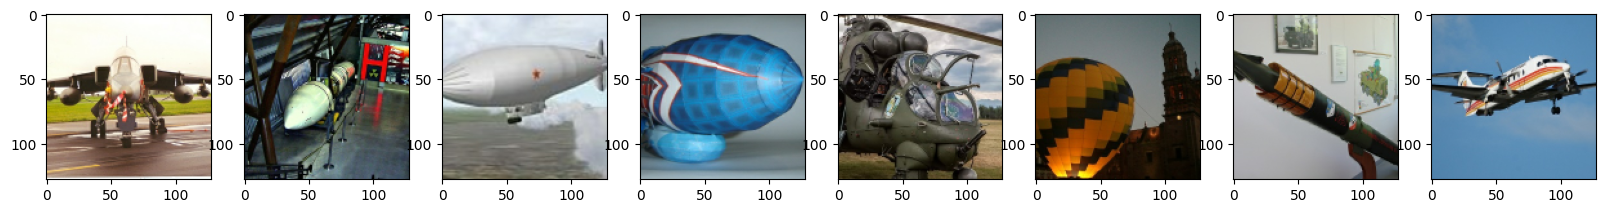

In [ ]:
# Setup the subplot formatting 
fig, ax = pyplot.subplots(ncols=8, figsize=(20,20))
# Loop four times and get images 
for idx in range(8): 
    index = randint(0, len(dataset))
    # Grab an image and label
    image = (dataset[index] + 1) / 2.0
    # Plot the image using a specific subplot 
    ax[idx].imshow(image)

# Creating a GAN: Combining a discriminator and a generator 

 
 

Define the generator and discriminator models using the functions created above, then wrap these models into a GAN. The number of latent dimensions used for input is also defined, and the parameters of the generator are summarized. 

In [ ]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
# create the discriminator
d_model = define_discriminator()
# create the gan
gan_model = define_gan(g_model, d_model)
# show model parameters
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 2048)       33556480  
 nspose)                                                         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 2048)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 1024)     33555456  
 ranspose)                                            

# Training the model

Engage the custom training loop by calling it with the parameters defined above.                                        

In [ ]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=600, n_batch=128)

# References

Abadi, A., Agarwal, P. B., Brevdo, E., Chen, Z., Citro, C., Corrado, G., Davis, A., Dean, J., Devin, M., Ghemawat, S., Goodfellow, I.,Harp, A., Irving, G., Isard, M., Jozefowicz, R., Jia Y., Kaiser, L., Kudlur, M., Levenberg, J., Mané, D., Schuster, M., Monga, R., Moore, S. Murray, D., Olah, C., Shlens, J., Steiner, B., Sutskever, I., Talwar, K., Tucker, P., Vanhoucke, V., Vasudevan, V., Viégas, F., Vinyals, O., Warden, P., Wattenberg, M., Wicke, M., Yu, Y., & Zheng. X., (2015). TensorFlow: Largescale machine learning on heterogeneous systems. Software available from tensorflow.org ​

Boe, Bryce. (2023). PRAW: The Python Reddit API Wrapper. Reddit.com​

Brownlee, Jason. (2019). Generative Adversarial Networks with Python. Machine Learning Mastery. EBook. ​

Chintala, Soumith. Denton, Emily. Arjovsky, Martin. Mathieu, Michael. (2023). How to Train a GAN? Tips and tciks to make GANs work. Githib. Retreived 4/2/2023 from guthub.com/soumith/ganhacks​

Chollet, Francois. (2015). Keras. GitHub. https://github.com/fchollet/keras  ​

Das Shuvo, Falguni. (2020). Repeatedly calling model.predict(...) results in memory leak. GitHub. Retrieved 3/15/2023 from https://github.com/keras-team/keras/issues/13118 https://machinelearningmastery.com/generative_adversarial_networks/​

Deng, Jia., Dong, Wei., Socher, Richard., Li, Li-Jia., Li, Kia., Fei-Fei, Li. (2009). ImageNet: A large-scale hierarchical image database. IEEE Conference on Computer Vision and Pattern Recognition.   pp. 248-255, doi: 10.1109/CVPR.2009.5206848.​

Harris, C.R., Millman, K.J., van der Walt, S.J. et al. (2020) Array programming with NumPy. Nature 585, 357–362. DOI: 10.1038/s41586-020-2649-2 ​

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering. https://zenodo.org/badge/DOI/10.5281/zenodo.592536.svg ​

Karras, Tero. Aila, Timo. Laine, Samuli. Lehtinen, Jaakko. (2017). Progressive Growing of GANs for Improved Quality, Stability, and Variation. arXiv:1710.10196 ​

Krizhevsky, Alex. Sutskever, Ilya. & Hinton, Geoffrey. (2017). ImageNet classification with deep convolutional neural networks. Communications of the ACM. 60(8). DOI: 10.1145/3065386​

Lower, Jacob. (2022). RedditImageScraper. retrieved 01/13/2023 from https://github.com/ClarityCoders/RedditImageScraper​

OpenCV Team. (2023). ComputerVision2 (cv2). Opencv.org ​

Regis Jesuit University. (2021). MSDS600 Intro to Data Science . Regis University​

Regis Jesuit University. (2022). MSDS660 Deep Learning. Regis University​

Renotte, Nicholas. (2022). GANBasics. Github.com. Retrieved 04/01/2023 from  githuib.com/nicknochnack/GANBasics​

r/helicopters. (2023). Image dataset. Reddit.com. Retrieved 03/26/2023​

r/warplaneporn. (2023). Image dataset. Reddit.com. Retrieved 03/26/2023